In [1]:
# !pip install hdf5storage
# !git clone https://github.com/adityajn105/brain-tumor-segmentation-unet
# !bash tumor-segmentation-unet/download_data.sh
# !python mat_to_numpy.py brain_tumor_dataset/
!pip install scikit-image
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 94.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 55.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 45.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 47.0 MB/s eta 0:00:00


In [2]:
# import zipfile as zf

# files = zf.ZipFile("dataset.zip",'r')
# files.extractall()
# files.close()

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

##Load images, labels, masks
labels = np.load('dataset/labels.npy')
images = np.clip( (np.load('dataset/images.npy')/12728),0,1)
masks = np.load('dataset/masks.npy')*1
print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


In [4]:
from skimage.transform import resize
img_size_ori = 512
img_size_target = 128

images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
  
images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape)  

(3064, 128, 128, 1)
(3064, 128, 128, 1)


[ 708 1426  930]


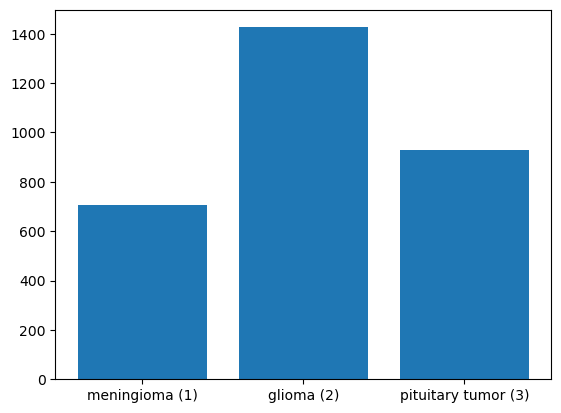

In [5]:
classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

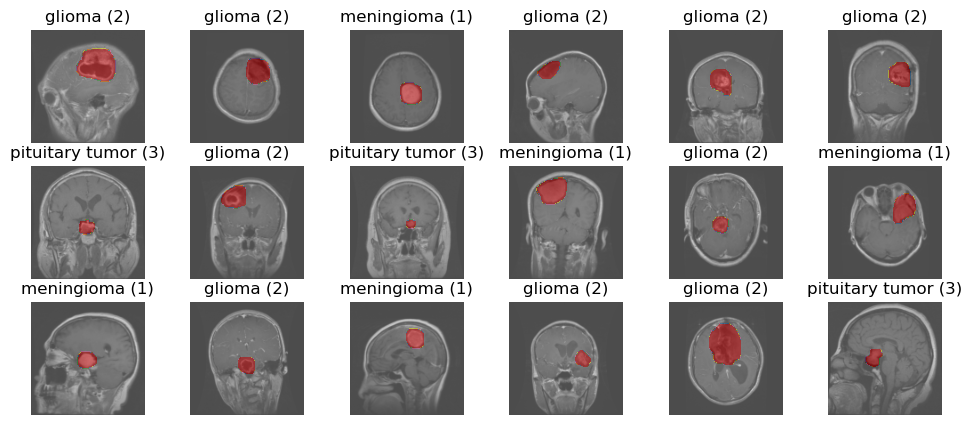

In [6]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Train Image and its mask which is to be predicted

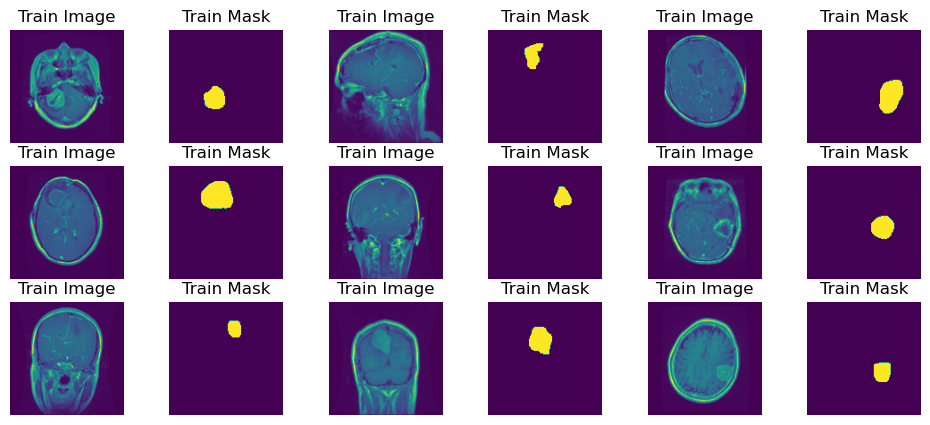

In [7]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(images[idx],axis=-1))
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(masks[idx],axis=-1)) 
  plt.title("Train Mask")
  plt.axis('off')

In [8]:
from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( images,masks,test_size=0.2,stratify=labels)
del images
del masks
del labels
gc.collect()
X.shape,X_v.shape

((2451, 128, 128, 1), (613, 128, 128, 1))

### Augmentation

In [9]:
X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
X.shape,Y.shape

((4902, 128, 128, 1), (4902, 128, 128, 1))

In [10]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

2022-11-19 17:10:30.794643: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Defining the Model

In [11]:
from keras import backend as K
from keras.layers import Layer

class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "padding": self.padding,
            "pool_size": self.pool_size,
            "strides": self.strides,
        })
        return config

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]


    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "size": self.size,
        })
        return config

    def call(self, inputs, output_shape=None):
        # one is pool and one is mask
        updates, mask = inputs[0], inputs[1]

        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')     # it gives a dynamic shape of a given tensor. 

            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
            b = one_like_mask * batch_range

            y = mask // (output_shape[2] * output_shape[3])

            x = (mask // output_shape[3]) % output_shape[2]

            feature_range = tf.range(output_shape[3], dtype='int32')

            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)       # Prints the number of elements in the updates
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [12]:
from keras.models import Model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Activation, Reshape, Dense
from keras.layers.convolutional import Convolution2D
import tensorflow as tf
from keras import optimizers

IMG_DIM = (128,128,1)
kernel=3
pool_size = (2,2)
output_mode="sigmoid"
n_labels=1
inputs = Input( shape=IMG_DIM )

conv_1 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation("relu")(conv_1)
conv_2 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation("relu")(conv_2)
pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size, name="block1_pool")(conv_2)

conv_3 = Convolution2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation("relu")(conv_3)
conv_4 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
conv_4 = BatchNormalization()(conv_4)
conv_4 = Activation("relu")(conv_4)

pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size, name="block2_pool")(conv_4)

conv_5 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
conv_5 = BatchNormalization()(conv_5)
conv_5 = Activation("relu")(conv_5)
conv_6 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
conv_6 = BatchNormalization()(conv_6)
conv_6 = Activation("relu")(conv_6)
conv_7 = Convolution2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
conv_7 = BatchNormalization()(conv_7)
conv_7 = Activation("relu")(conv_7)

pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size, name="block3_pool")(conv_7)

conv_8 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
conv_8 = BatchNormalization()(conv_8)
conv_8 = Activation("relu")(conv_8)
conv_9 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
conv_9 = BatchNormalization()(conv_9)
conv_9 = Activation("relu")(conv_9)
conv_10 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
conv_10 = BatchNormalization()(conv_10)
conv_10 = Activation("relu")(conv_10)

pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size, name="block4_pool")(conv_10)

conv_11 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
conv_11 = BatchNormalization()(conv_11)
conv_11 = Activation("relu")(conv_11)
conv_12 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
conv_12 = BatchNormalization()(conv_12)
conv_12 = Activation("relu")(conv_12)
conv_13 = Convolution2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
conv_13 = BatchNormalization()(conv_13)
conv_13 = Activation("relu")(conv_13)

pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size, name="block5_pool")(conv_13)

# decoder
unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

conv_14 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
conv_14 = BatchNormalization()(conv_14)
conv_14 = Activation("relu")(conv_14)
conv_15 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
conv_15 = BatchNormalization()(conv_15)
conv_15 = Activation("relu")(conv_15)
conv_16 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
conv_16 = BatchNormalization()(conv_16)
conv_16 = Activation("relu")(conv_16)

unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

conv_17 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
conv_17 = BatchNormalization()(conv_17)
conv_17 = Activation("relu")(conv_17)
conv_18 = Convolution2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
conv_18 = BatchNormalization()(conv_18)
conv_18 = Activation("relu")(conv_18)
conv_19 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
conv_19 = BatchNormalization()(conv_19)
conv_19 = Activation("relu")(conv_19)

unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

conv_20 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
conv_20 = BatchNormalization()(conv_20)
conv_20 = Activation("relu")(conv_20)
conv_21 = Convolution2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
conv_21 = BatchNormalization()(conv_21)
conv_21 = Activation("relu")(conv_21)
conv_22 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
conv_22 = BatchNormalization()(conv_22)
conv_22 = Activation("relu")(conv_22)

unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

conv_23 = Convolution2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
conv_23 = BatchNormalization()(conv_23)
conv_23 = Activation("relu")(conv_23)
conv_24 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
conv_24 = BatchNormalization()(conv_24)
conv_24 = Activation("relu")(conv_24)

unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

conv_25 = Convolution2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
conv_25 = BatchNormalization()(conv_25)
conv_25 = Activation("relu")(conv_25)

conv_26 = Convolution2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
conv_26 = BatchNormalization()(conv_26)

conv_26 = Dense(1)(conv_26)
out = Activation(output_mode)(conv_26)

model = Model( inputs, out )
model.summary()

2022-11-19 17:10:38.912409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 17:10:39.003469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 17:10:39.004192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 17:10:39.005665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

### Defining Dice Coefficient & Loss
Dice = 2|A∩B|/|A|+|B|

In [13]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Defining IOU metric and compile Model

In [14]:
THRESHOLD = 0.5
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def iou_metric(label, pred):
    return tf.numpy_function(get_iou_vector, [label, pred>THRESHOLD], tf.float64)

model.compile(optimizer=optimizers.Adam(lr=1e-3), 
             loss=bce_dice_loss, metrics=['accuracy',iou_metric,dice_coefficient])


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

train_generator = train_datagen.flow(X, Y, batch_size=32)
val_generator = val_datagen.flow(X_v, Y_v, batch_size=32)

hist = model.fit(X,Y,batch_size=32,epochs=100,
               validation_split=0.25,verbose=1,callbacks= callback_list)


Epoch 1/100


2022-11-19 17:10:47.829191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-19 17:10:49.991327: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 17:10:49.992277: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 17:10:49.992320: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-19 17:10:49.993377: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 17:10:49.994054: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


115/115 [==============================] - ETA: 0s - loss: 1.6001 - accuracy: 0.9350 - iou_metric: 0.0263 - dice_coefficient: 0.0499
Epoch 1: val_loss improved from inf to 1.52148, saving model to model_best_checkpoint.h5
115/115 [==============================] - 87s 638ms/step - loss: 1.6001 - accuracy: 0.9350 - iou_metric: 0.0263 - dice_coefficient: 0.0499 - val_loss: 1.5215 - val_accuracy: 0.9704 - val_iou_metric: 0.0184 - val_dice_coefficient: 0.0489 - lr: 0.0010
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 1.4544 - accuracy: 0.8893 - iou_metric: 0.1403 - dice_coefficient: 0.0731
Epoch 2: val_loss improved from 1.52148 to 1.51356, saving model to model_best_checkpoint.h5
115/115 [==============================] - 69s 598ms/step - loss: 1.4544 - accuracy: 0.8893 - iou_metric: 0.1403 - dice_coefficient: 0.0731 - val_loss: 1.5136 - val_accuracy: 0.8253 - val_iou_metric: 0.1112 - val_dice_coefficient: 0.0791 - lr: 0.0010
Epoch 3/100
115/115 [=================

In [16]:
model = load_model('model_best_checkpoint.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':iou_metric,'dice_coefficient':dice_coefficient,'MaxPoolingWithArgmax2D':MaxPoolingWithArgmax2D,'MaxUnpooling2D':MaxUnpooling2D}) #or compile = False

### Plot graph of Dice Loss, IoU Metric, and Dice Coefficient

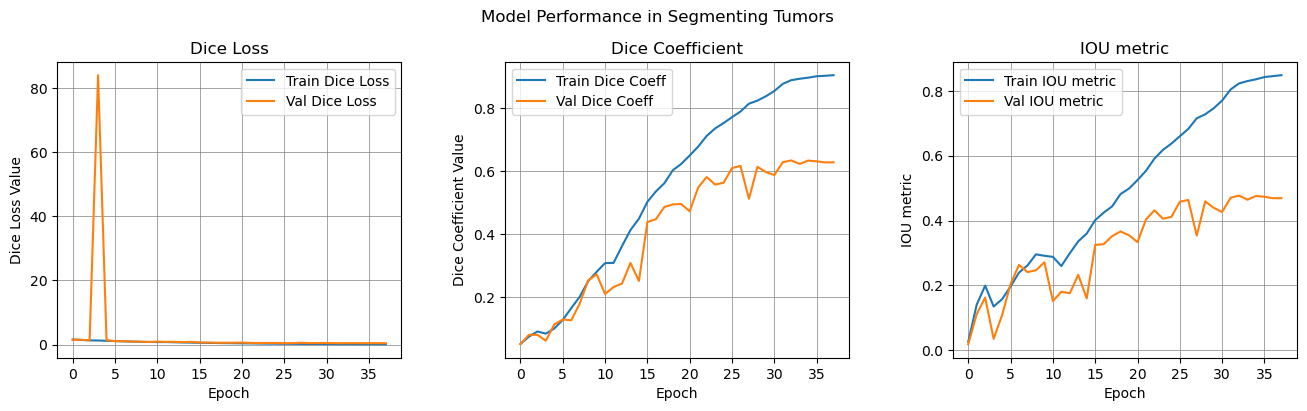

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Model Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['loss'], label='Train Dice Loss')
ax1.plot(epoch_list, hist.history['val_loss'], label='Val Dice Loss')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Dice Loss Value');ax1.set_xlabel('Epoch');ax1.set_title('Dice Loss')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['dice_coefficient'], label='Train Dice Coeff')
ax2.plot(epoch_list, hist.history['val_dice_coefficient'], label='Val Dice Coeff')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Dice Coefficient Value');ax2.set_xlabel('Epoch');ax2.set_title('Dice Coefficient')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_iou_metric'], label='Val IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

### Plot IoU Curve using different Thresholds

In [18]:
def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

154/154 [==============================] - 43s 280ms/step


Text(0.5, 1.0, 'Threshold vs IoU (0.3333, 0.7462)')

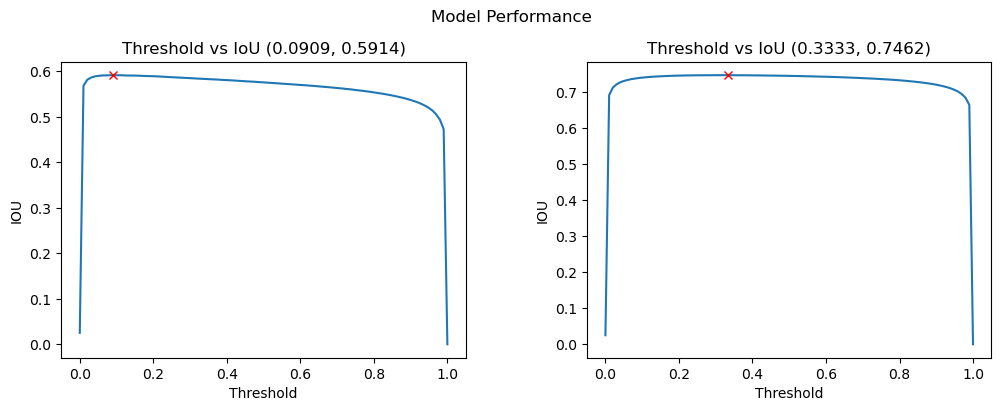

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,model.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(round(th_best, 4), round(iou_best, 4)))

th, ious, iou_best, th_best = getIOUCurve(Y,model.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax2.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(round(th_best, 4), round(iou_best, 4)))

### Determine IoU and Dice Coefficient for Threshold=0.5

In [20]:
pred_mask = model.predict(X_v)
iou_score = iou_metric(Y_v, pred_mask)
dice_coeff = dice_coefficient(Y_v, pred_mask)
print("IoU score is: ", tf.get_static_value(iou_score))
print("Dice Coefficient is: ", tf.get_static_value(dice_coeff))

20/20 [==============================] - 5s 263ms/step
IoU score is:  0.5755359872120253
Dice Coefficient is:  0.72044146


### Predict Masks

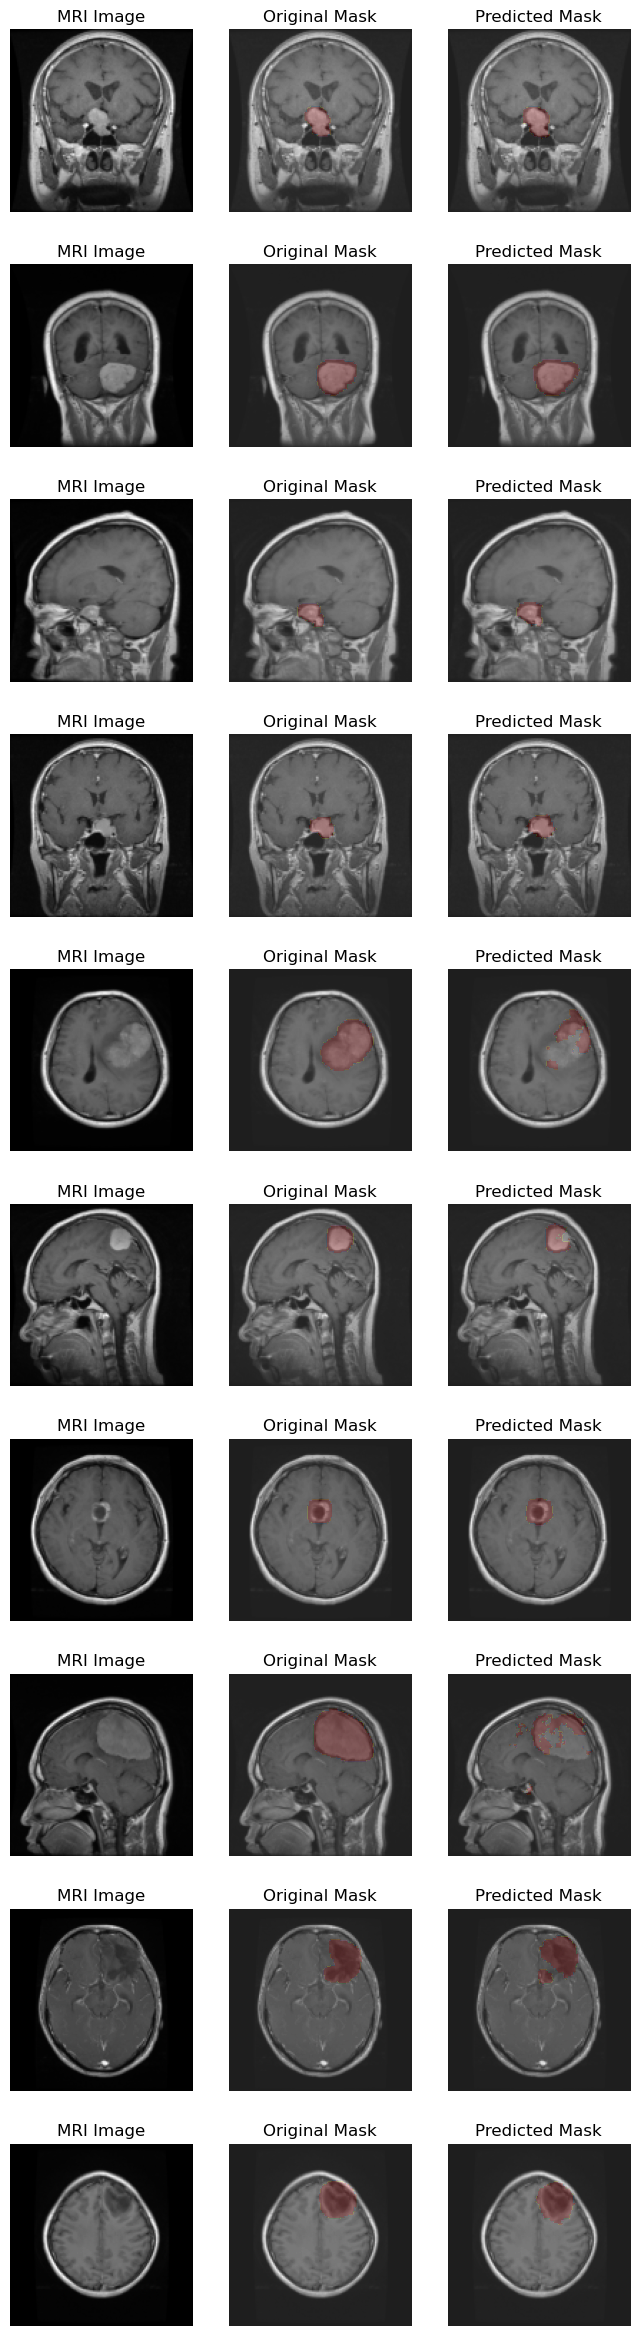

In [21]:
predicted_mask = pred_mask>THRESHOLD

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like( Y_v[0] )
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - Y_v[idx],axis=-1), alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(temp - predicted_mask[idx],axis=-1),  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')